In [26]:
import json

# Load configuration and define a global variable
def load_config():
    global config
    with open('config_MolProbity.json') as config_file:
        config = json.load(config_file)

# Call the function to load the configuration
load_config()

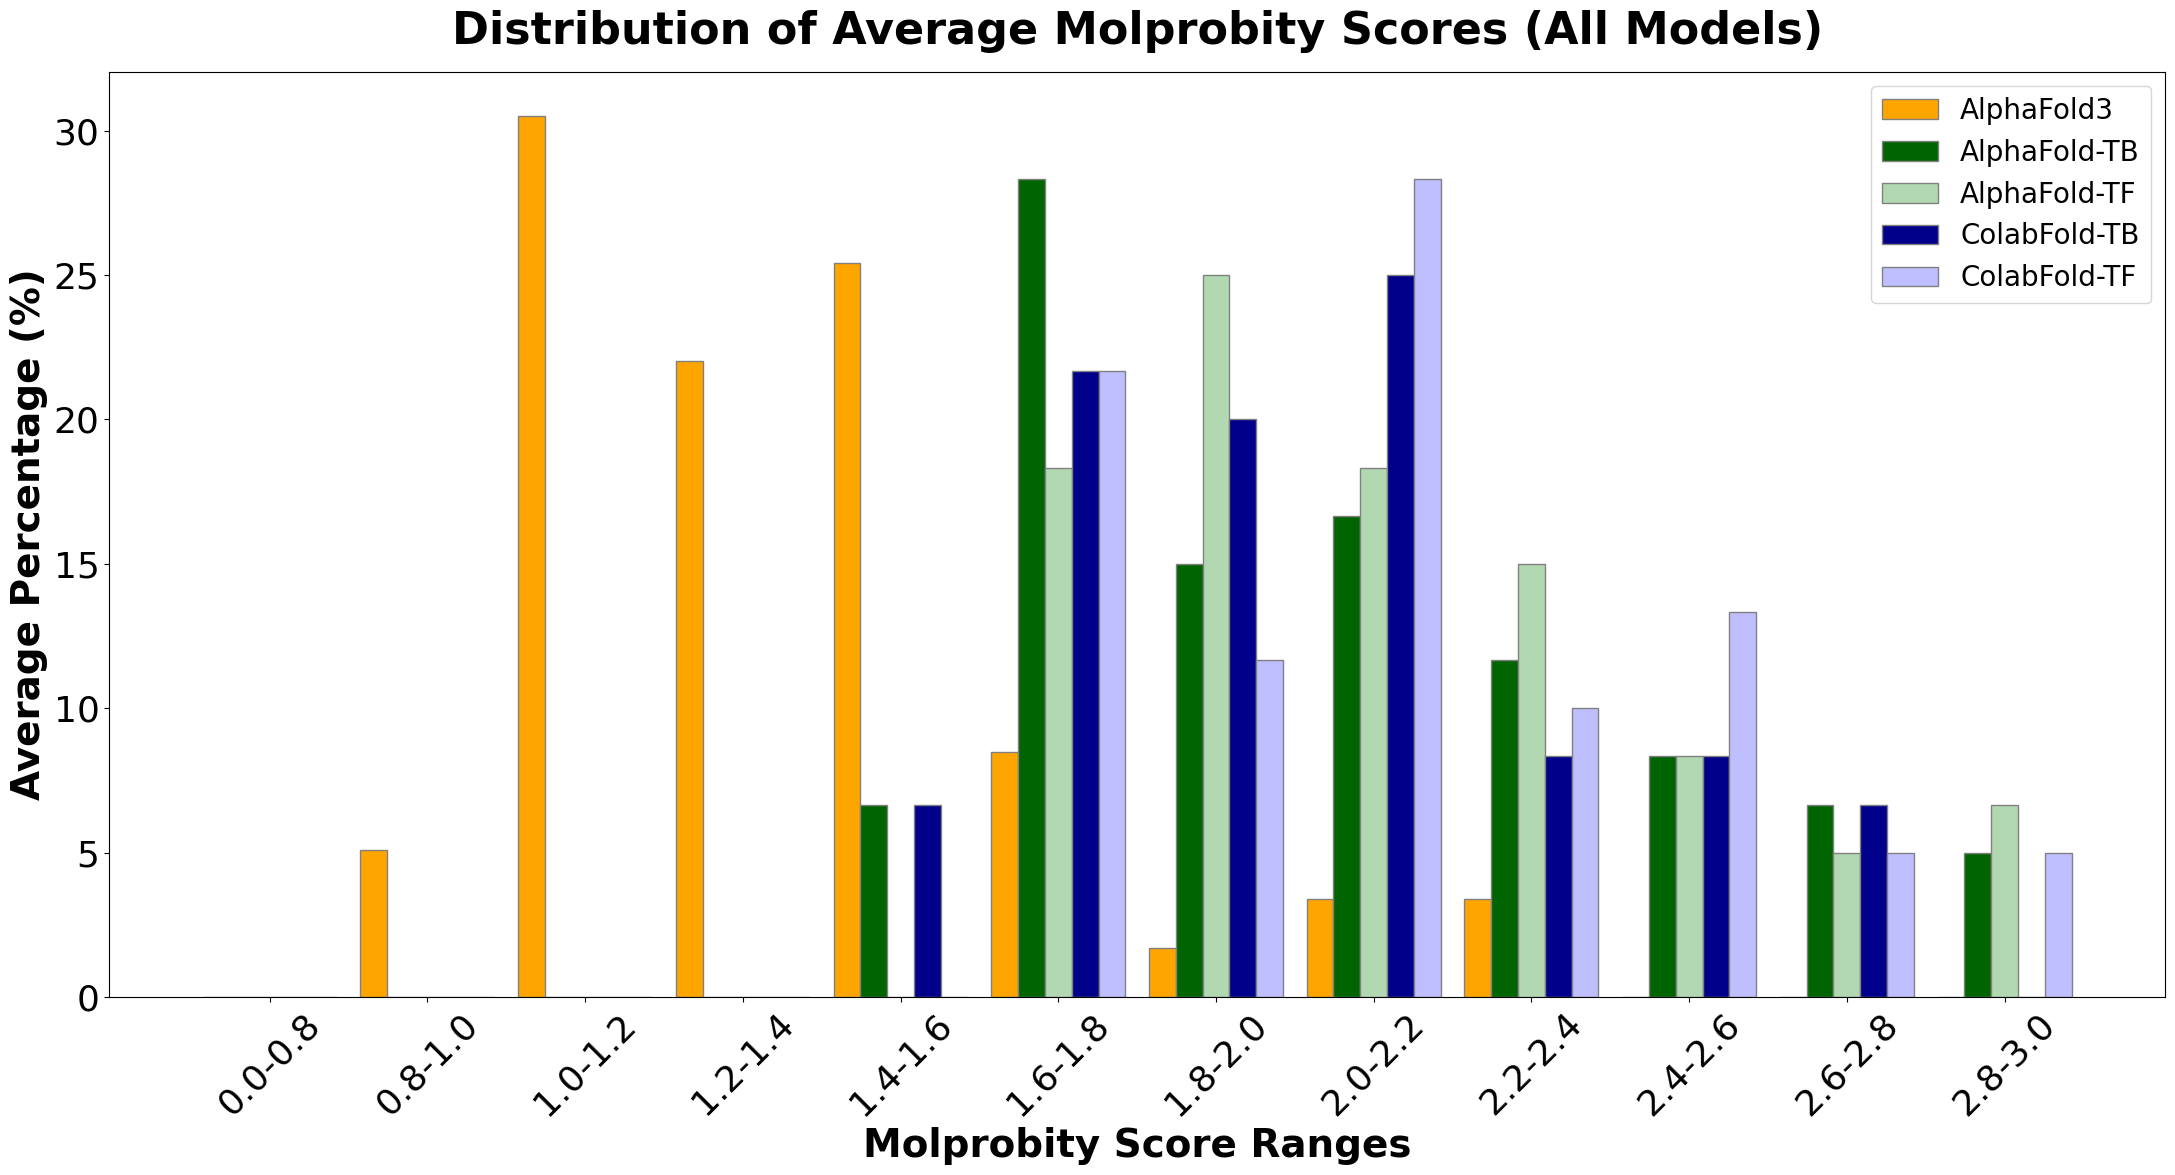

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import json

# Load configuration and define a global variable
def load_config():
    global config
    with open('config_MolProbity.json') as config_file:
        config = json.load(config_file)

# Call the function to load the configuration
load_config()

# Set global font sizes and styles for the plot
plt.rcParams.update({
    'font.size': 15, 
    'axes.labelsize': 20, 
    'axes.titlesize': 32, 
    'xtick.labelsize': 26, 
    'ytick.labelsize': 26, 
    'legend.fontsize': 20
})

# Function to process each directory and return the Molprobity score distributions
def process_directory(directory_path):
    # Define a consolidated range and initialize counts
    consolidated_range = '0.0-0.8'
    range_counts = {consolidated_range: 0}
    # Update range increment to 0.2
    range_counts.update({f"{i/10:.1f}-{(i/10 + 0.2):.1f}": 0 for i in range(8, 30, 2)})

    total_files = 0

    for file in os.listdir(directory_path):
        if file.endswith(".xlsx") and not file.startswith("~$"):
            file_path = os.path.join(directory_path, file)
            try:
                df = pd.read_excel(file_path)
                average_score = df['Molprobity_score'].mean()
                # Adjust index calculation for 0.2 intervals
                index = int(average_score * 10 // 2) * 2
                if 0 <= index < 8:
                    range_counts[consolidated_range] += 1
                elif 8 <= index < 30:
                    range_key = f"{index/10:.1f}-{(index/10 + 0.2):.1f}"
                    range_counts[range_key] += 1
                total_files += 1
            except Exception as e:
                print(f"Error processing file {file}: {e}")

    # Calculate percentages
    range_percentages = {k: (v / total_files * 100) if total_files else 0 for k, v in range_counts.items()}
    return list(range_percentages.keys()), list(range_percentages.values())

# Directory paths and their corresponding categories with specific colors
directories = {
    'AlphaFold3': (config['AlphaFold3_directory'], 'orange'),
    'AlphaFold-TB': (config['AlphaFold_TB_directory'], 'darkgreen'),
    'AlphaFold-TF': (config['AlphaFold_TF_directory'], '#b2d8b2'),
    'ColabFold-TB': (config['ColabFold_TB_directory'], 'darkblue'),
    'ColabFold-TF': (config['ColabFold_TF_directory'], '#bfbfff')
}

fig, ax = plt.subplots(figsize=(22, 12))  # Increased the figure size
fig.patch.set_facecolor('white')  # Set the background color of the figure to white
ax.set_facecolor('white')  # Set the background color of the axes to white

bar_width = 0.17  # Adjusted bar width for more bars

# Plotting
for i, (category, (directory_path, color)) in enumerate(directories.items()):
    labels, percentages = process_directory(directory_path)
    bar_positions = [x + (bar_width * i) for x in range(len(labels))]
    ax.bar(bar_positions, percentages, width=bar_width, color=color, label=category, edgecolor='grey')

ax.set_ylabel('Average Percentage (%)', fontsize=28, fontweight='bold')  # Increased font size
ax.set_xlabel('Molprobity Score Ranges', fontsize=28, fontweight='bold')  # Increased font size
ax.set_xticks([x + bar_width / 2 * (len(directories) - 1) for x in range(len(labels))])
ax.set_xticklabels(labels, rotation=45)
plt.title('Distribution of Average Molprobity Scores (All Models)', fontweight='bold', pad=20)
plt.legend()
plt.tight_layout()

# Save the figure in the specified directory at 1000 DPI
output_directory = config['Main_Figures_directory']
plt.savefig(os.path.join(output_directory, 'Fig_2a.png'), dpi=1000, facecolor='white')

plt.show()


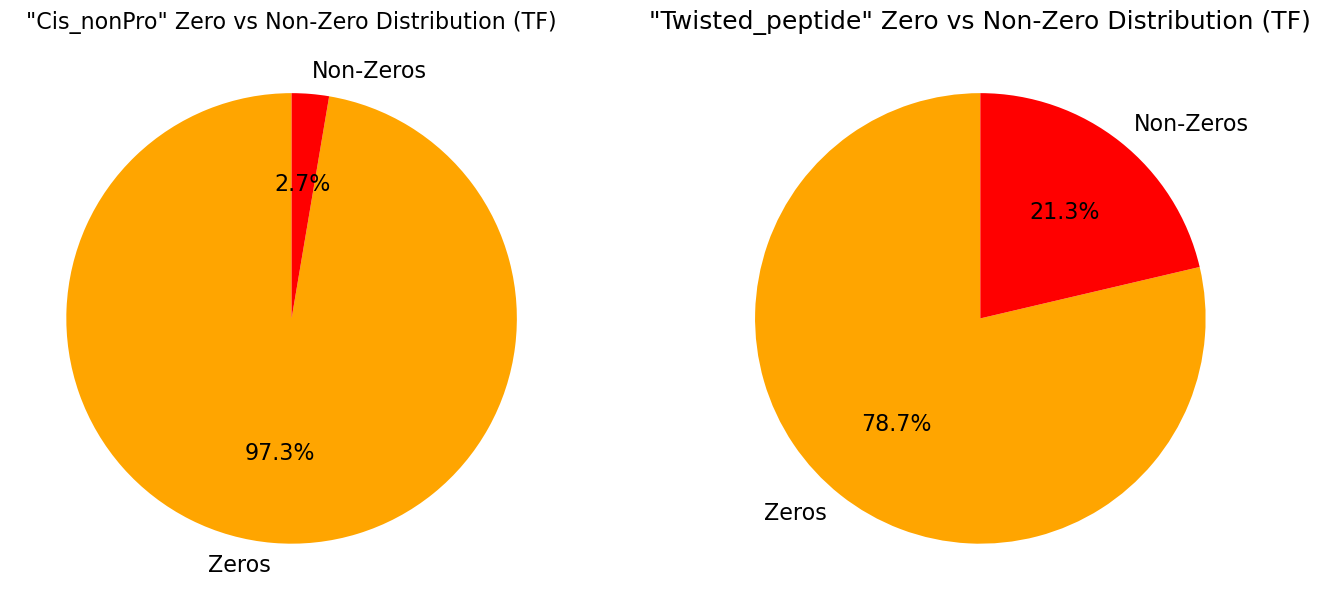

In [5]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import json

# Load configuration and define a global variable
def load_config():
    global config
    with open('config_MolProbity.json') as config_file:
        config = json.load(config_file)

# Call the function to load the configuration
load_config()

# Specify the directory containing the Excel files from the config file
directory_path = config['ColabFold_TF_directory']

# Initialize aggregate counters
total_zeros_cis_nonpro = total_nonzeros_cis_nonpro = 0
total_zeros_twisted_peptide = total_nonzeros_twisted_peptide = 0
total_samples_cis_nonpro = total_samples_twisted_peptide = 0

# Function to process each Excel file
def process_excel_file(file_path):
    global total_zeros_cis_nonpro, total_nonzeros_cis_nonpro, total_zeros_twisted_peptide, total_nonzeros_twisted_peptide, total_samples_cis_nonpro, total_samples_twisted_peptide
    
    df = pd.read_excel(file_path)

    # Analyze "Cis_nonPro" column
    total_zeros_cis_nonpro += (df['Cis_nonPro'] == 0).sum()
    total_nonzeros_cis_nonpro += (df['Cis_nonPro'] != 0).sum()
    total_samples_cis_nonpro += len(df['Cis_nonPro'])

    # Analyze "Twisted_peptide" column
    total_zeros_twisted_peptide += (df['Twisted_peptide'] == 0).sum()
    total_nonzeros_twisted_peptide += (df['Twisted_peptide'] != 0).sum()
    total_samples_twisted_peptide += len(df['Twisted_peptide'])

# Iterate through all files in the specified directory and process them
for file_name in os.listdir(directory_path):
    if file_name.endswith(".xlsx") and not file_name.startswith("~$"):
        file_path = os.path.join(directory_path, file_name)
        try:
            process_excel_file(file_path)
        except Exception as e:
            print(f"Could not process {file_name}: {e}")

# Calculate overall percentages
overall_percent_zeros_cis_nonpro = (total_zeros_cis_nonpro / total_samples_cis_nonpro) * 100
overall_percent_nonzeros_cis_nonpro = (total_nonzeros_cis_nonpro / total_samples_cis_nonpro) * 100

overall_percent_zeros_twisted_peptide = (total_zeros_twisted_peptide / total_samples_twisted_peptide) * 100
overall_percent_nonzeros_twisted_peptide = (total_nonzeros_twisted_peptide / total_samples_twisted_peptide) * 100

# Plotting pie charts
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# Custom colors
colors_zero_nonzero = ['orange', 'red']

# Increase font size for all text
font_size = 16  # You can adjust this value as needed
font_size_title = 18

# Pie chart for "Cis_nonPro"
axs[0].pie([overall_percent_zeros_cis_nonpro, overall_percent_nonzeros_cis_nonpro], labels=['Zeros', 'Non-Zeros'], autopct=lambda p: f'{p:.1f}%', startangle=90, colors=colors_zero_nonzero, textprops={'fontsize': font_size})
axs[0].set_title('"Cis_nonPro" Zero vs Non-Zero Distribution (TF)', fontsize=font_size)

# Pie chart for "Twisted_peptide"
axs[1].pie([overall_percent_zeros_twisted_peptide, overall_percent_nonzeros_twisted_peptide], labels=['Zeros', 'Non-Zeros'], autopct=lambda p: f'{p:.1f}%', startangle=90, colors=colors_zero_nonzero, textprops={'fontsize': font_size})
axs[1].set_title('"Twisted_peptide" Zero vs Non-Zero Distribution (TF)', fontsize=font_size_title)

plt.tight_layout()
plt.show()


In [7]:
import pandas as pd
import glob
import os
import json

# Load configuration and define a global variable
def load_config():
    global config
    with open('config_MolProbity.json') as config_file:
        config = json.load(config_file)

# Call the function to load the configuration
load_config()

def extract_data_from_excel(input_file):
    # Extract pdb_id from the filename
    pdb_id = os.path.basename(input_file).split('_')[-1].split('.')[0]
    
    try:
        # Read the Excel file
        data = pd.read_excel(input_file, engine='openpyxl', index_col='Unnamed: 0')
        
        # Ensure there's a row named 'ranked_0.pdb_clean.pdb' before attempting to access it
        if 'ranked_0.pdb_clean.pdb' in data.index:
            cis_nonpro = data.at['ranked_0.pdb_clean.pdb', 'Cis_nonPro']
            twisted_peptide = data.at['ranked_0.pdb_clean.pdb', 'Twisted_peptide']
            clashscore = data.at['ranked_0.pdb_clean.pdb', 'Clashscore']
        else:
            cis_nonpro = twisted_peptide = clashscore = "Not Found"
            
    except Exception as e:
        print(f"Error processing file {input_file}: {e}")
        return pd.DataFrame()
    
    # Create a new DataFrame for the output
    return pd.DataFrame({
        'pdb_id': [pdb_id],
        'Cis_nonPro': [cis_nonpro],
        'Twisted_peptide': [twisted_peptide],
        'Clashscore': [clashscore]
    })

def process_directory(directory_path, output_directory):
    # Pattern to match all Excel files
    pattern = os.path.join(directory_path, 'Binding_Molprobity_TB_*.xlsx')
    files = glob.glob(pattern)
    
    # DataFrame to collect results from all files
    all_data = pd.DataFrame()
    
    for file in files:
        file_data = extract_data_from_excel(file)
        all_data = pd.concat([all_data, file_data], ignore_index=True)
        
    # Ensure the output directory exists
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    # Define the output filename
    output_file = os.path.join(output_directory, "ColabFold_First_TB.xlsx")
    
    # Write to a new Excel file
    all_data.to_excel(output_file, index=False)
    print(f"All data extracted and written to {output_file}")

# Example usage
directory_path = config['ColabFold_TB_directory']
output_directory = config['Molprobity_First_directory']
process_directory(directory_path, output_directory)


All data extracted and written to /Users/neginmanshour/Desktop/PpEv/Quality_Scoring_Functions/Quality_Functions/MolProbity/Data/Molprobity_First/ColabFold_First_TB.xlsx


cis_nonpro_zero = 95.0


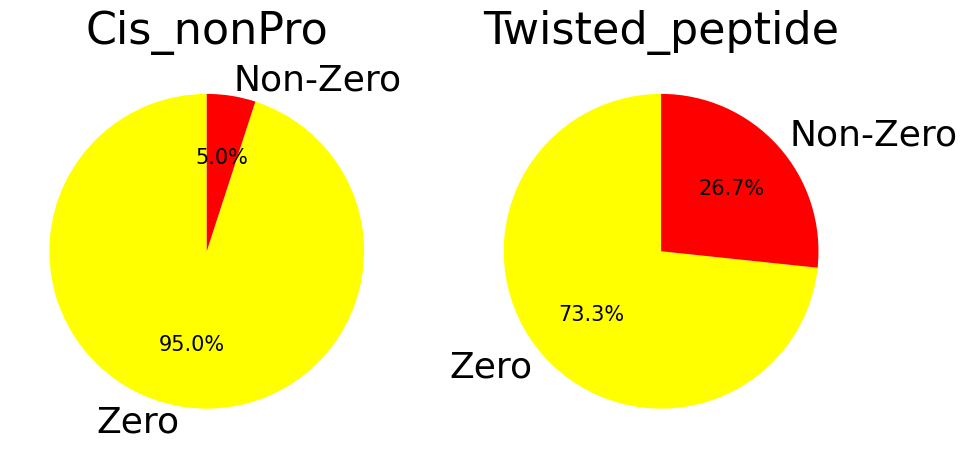

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file using the path from the config variable
data = pd.read_excel(config['Molprobity_First_directory'] + '/ColabFold_First_TF.xlsx')

# Calculate percentages for Cis_nonPro
cis_nonpro_zero = (data['Cis_nonPro'] == 0).mean() * 100
print("cis_nonpro_zero =", cis_nonpro_zero)
cis_nonpro_non_zero = 100 - cis_nonpro_zero

# Calculate percentages for Twisted_peptide
twisted_peptide_zero = (data['Twisted_peptide'] == 0).mean() * 100
twisted_peptide_non_zero = 100 - twisted_peptide_zero

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Cis_nonPro Pie Chart
ax[0].pie([cis_nonpro_zero, cis_nonpro_non_zero], labels=['Zero', 'Non-Zero'], colors=['yellow', 'red'], autopct='%1.1f%%', startangle=90)
ax[0].set_title('Cis_nonPro')

# Twisted_peptide Pie Chart
ax[1].pie([twisted_peptide_zero, twisted_peptide_non_zero], labels=['Zero', 'Non-Zero'], colors=['yellow', 'red'], autopct='%1.1f%%', startangle=90)
ax[1].set_title('Twisted_peptide')

plt.tight_layout()
plt.show()


In [9]:
import pandas as pd
import glob
import os

def extract_data_from_excel(input_file):
    # Extract pdb_id from the filename
    pdb_id = os.path.basename(input_file).split('_')[-1].split('.')[0]
    
    try:
        # Read the Excel file
        data = pd.read_excel(input_file, engine='openpyxl', index_col='Unnamed: 0')
        
        # Initialize variables
        cis_nonpro = twisted_peptide = clashscore = "Not Found"
        
        # Loop through the index to find the desired row
        for index_value in data.index:
            if index_value.endswith("_model_0.pdb_clean.pdb"):
                cis_nonpro = data.at[index_value, 'Cis_nonPro']
                twisted_peptide = data.at[index_value, 'Twisted_peptide']
                clashscore = data.at[index_value, 'Clashscore']
                break
            
    except Exception as e:
        print(f"Error processing file {input_file}: {e}")
    
    # Create a new DataFrame for the output
    return pd.DataFrame({
        'pdb_id': [pdb_id],
        'Cis_nonPro': [cis_nonpro],
        'Twisted_peptide': [twisted_peptide],
        'Clashscore': [clashscore]
    })

def process_directory(directory_path, output_directory):
    # Pattern to match all Excel files
    pattern = os.path.join(directory_path, 'Binding_Molprobity_Colab_AF3_*.xlsx')
    files = glob.glob(pattern)
    
    # DataFrame to collect results from all files
    all_data = pd.DataFrame()
    
    for file in files:
        file_data = extract_data_from_excel(file)
        all_data = pd.concat([all_data, file_data], ignore_index=True)
        
    # Ensure the output directory exists
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    # Define the output filename
    output_file = os.path.join(output_directory, "AF3_First.xlsx")
    
    # Write to a new Excel file
    all_data.to_excel(output_file, index=False)
    print(f"All data extracted and written to {output_file}")

# Example usage using paths from the config variable
directory_path = config['AlphaFold3_directory']
output_directory = config['Molprobity_First_directory']
process_directory(directory_path, output_directory)


All data extracted and written to /Users/neginmanshour/Desktop/PpEv/Quality_Scoring_Functions/Quality_Functions/MolProbity/Data/Molprobity_First/AF3_First.xlsx


In [10]:
import pandas as pd
import glob
import os

def extract_data_from_excel(input_file):
    # Extract pdb_id from the filename
    pdb_id = os.path.basename(input_file).split('_')[-1].split('.')[0]
    
    try:
        # Read the Excel file
        data = pd.read_excel(input_file, engine='openpyxl', index_col='Unnamed: 0')
        
        # Initialize variables
        cis_nonpro = twisted_peptide = clashscore = "Not Found"
        
        # Loop through the index to find the desired row
        for index_value in data.index:
            if index_value.endswith("_rank_1.pdb_clean.pdb"):
                cis_nonpro = data.at[index_value, 'Cis_nonPro']
                twisted_peptide = data.at[index_value, 'Twisted_peptide']
                clashscore = data.at[index_value, 'Clashscore']
                break
            
    except Exception as e:
        print(f"Error processing file {input_file}: {e}")
    
    # Create a new DataFrame for the output
    return pd.DataFrame({
        'pdb_id': [pdb_id],
        'Cis_nonPro': [cis_nonpro],
        'Twisted_peptide': [twisted_peptide],
        'Clashscore': [clashscore]
    })

def process_directory(directory_path, output_directory):
    # Pattern to match all Excel files
    pattern = os.path.join(directory_path, 'Binding_Molprobity_Colab_TF_*.xlsx')
    files = glob.glob(pattern)
    
    # DataFrame to collect results from all files
    all_data = pd.DataFrame()
    
    for file in files:
        file_data = extract_data_from_excel(file)
        all_data = pd.concat([all_data, file_data], ignore_index=True)
        
    # Ensure the output directory exists
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    # Define the output filename
    output_file = os.path.join(output_directory, "ColabFold_First_TF.xlsx")
    
    # Write to a new Excel file
    all_data.to_excel(output_file, index=False)
    print(f"All data extracted and written to {output_file}")

# Example usage using paths from the config variable
directory_path = config['ColabFold_TF_directory']
output_directory = config['Molprobity_First_directory']
process_directory(directory_path, output_directory)


All data extracted and written to /Users/neginmanshour/Desktop/PpEv/Quality_Scoring_Functions/Quality_Functions/MolProbity/Data/Molprobity_First/ColabFold_First_TF.xlsx


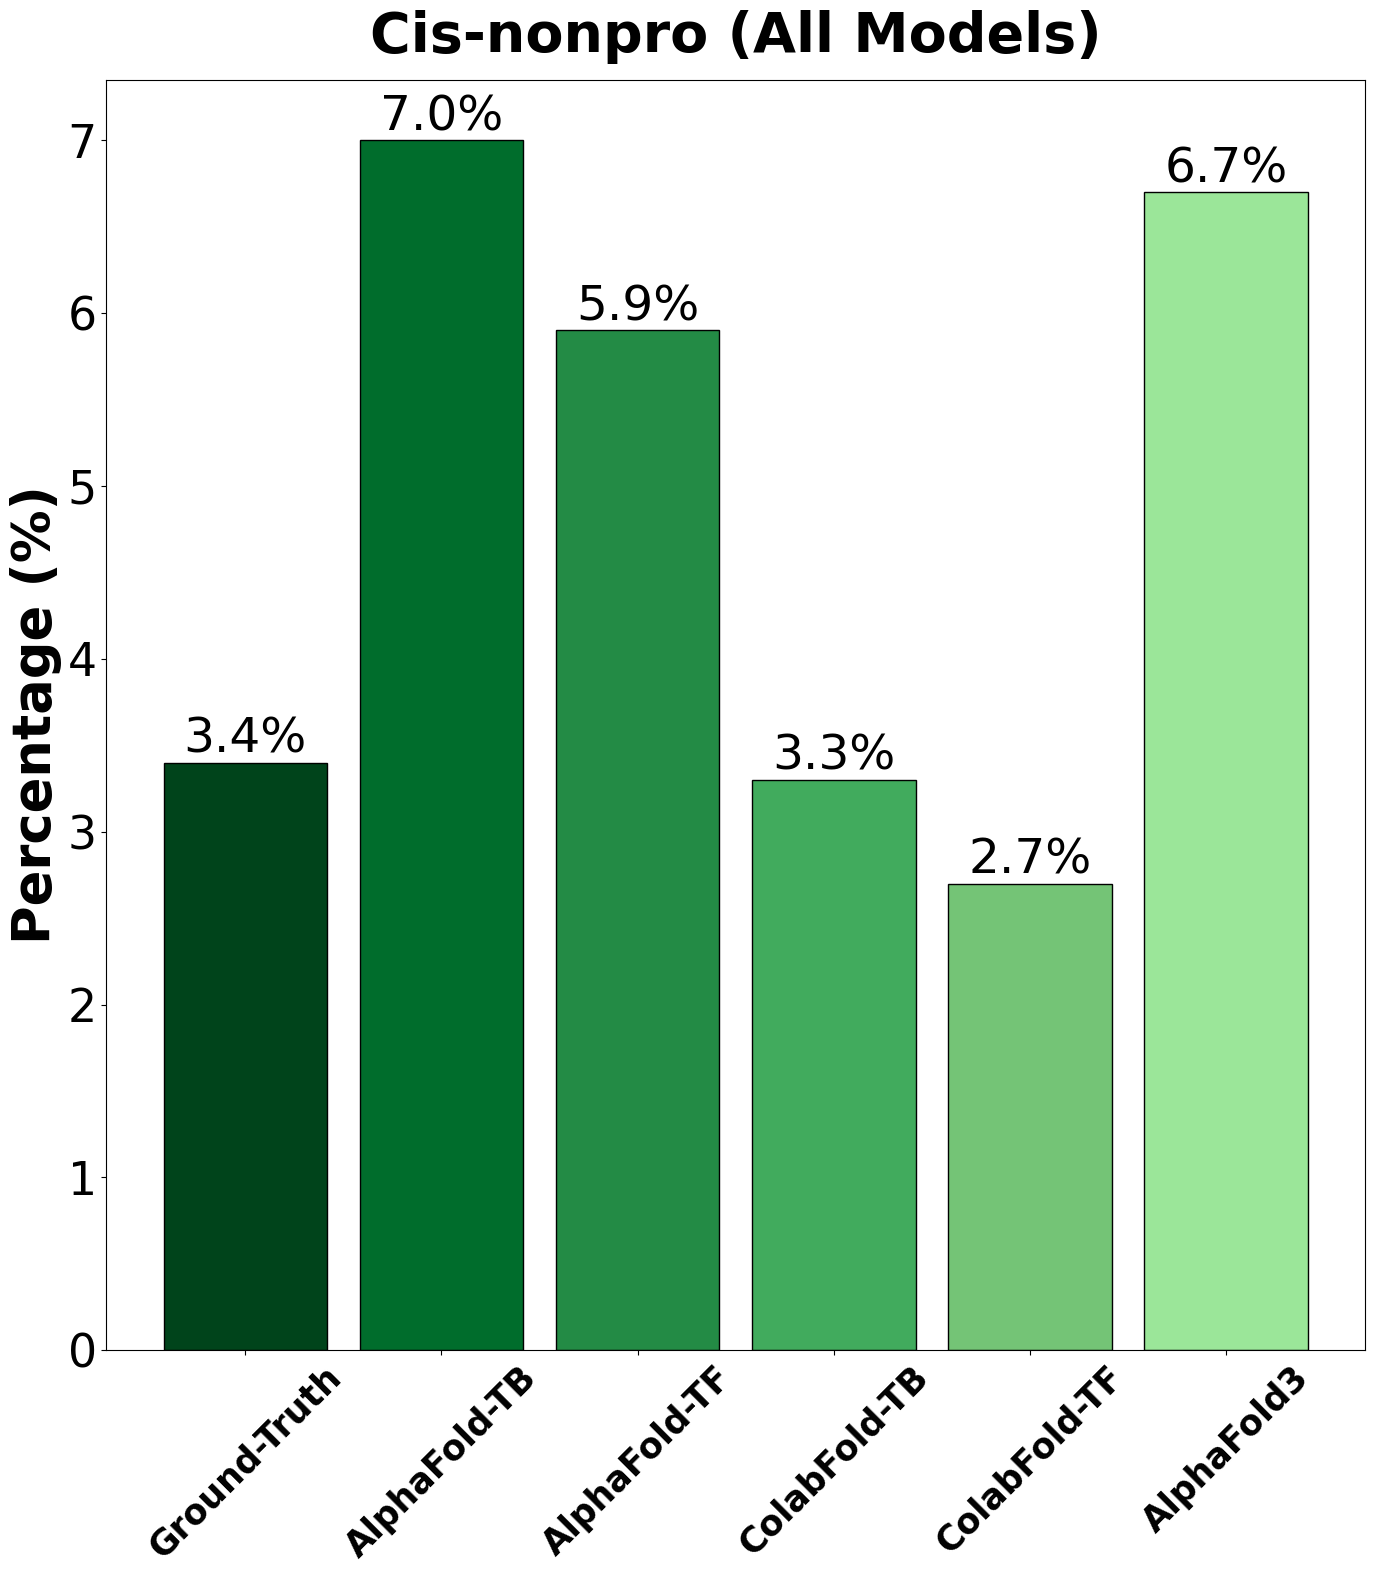

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the plot
categories = ['Ground-Truth', 'AlphaFold-TB', 'AlphaFold-TF', 'ColabFold-TB', 'ColabFold-TF', 'AlphaFold3']
non_zero_percentages = [3.4, 7, 5.9, 3.3, 2.7, 6.7]
colors_zero = ['#00441b', '#006d2c', '#238b45', '#41ab5d', '#74c476', '#9be699']

# Setup for plotting
fig, ax = plt.subplots(figsize=(14, 16))  # Adjusted figure size for tighter bars
bar_width = 0.5  # Increase bar width to fill more space

# Calculate positions to bring bars closer together
spacing = 0.1  # Decrease spacing between bars
non_zero_bar_positions = np.arange(len(categories)) * (bar_width + spacing)

# Plot bars
bars_non_zero = ax.bar(non_zero_bar_positions, non_zero_percentages, color=colors_zero, edgecolor='black', width=bar_width, label='Non-Zero')

# Labels above bars with larger font size
for bar, percentage in zip(bars_non_zero, non_zero_percentages):
    ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height(), f'{percentage:.1f}%', ha='center', va='bottom', fontsize=35)

# Set labels and legend
ax.set_ylabel('Percentage (%)', fontsize=38, fontweight='bold')
ax.set_xticks(non_zero_bar_positions)
ax.set_xticklabels(categories, rotation=45, fontsize=25, fontweight='bold')
ax.set_title('Cis-nonpro (All Models)', fontsize=40, fontweight='bold', pad=20)
plt.yticks(fontsize=33)
#plt.legend(fontsize=12)
plt.tight_layout()

# Save the figure using the path from the config variable
output_directory = config['Main_Figures_directory']
output_filename = 'Fig_2c_1.png'
output_path = os.path.join(output_directory, output_filename)
plt.savefig(output_path, format='png', dpi=1000)

# Display the plot
plt.show()


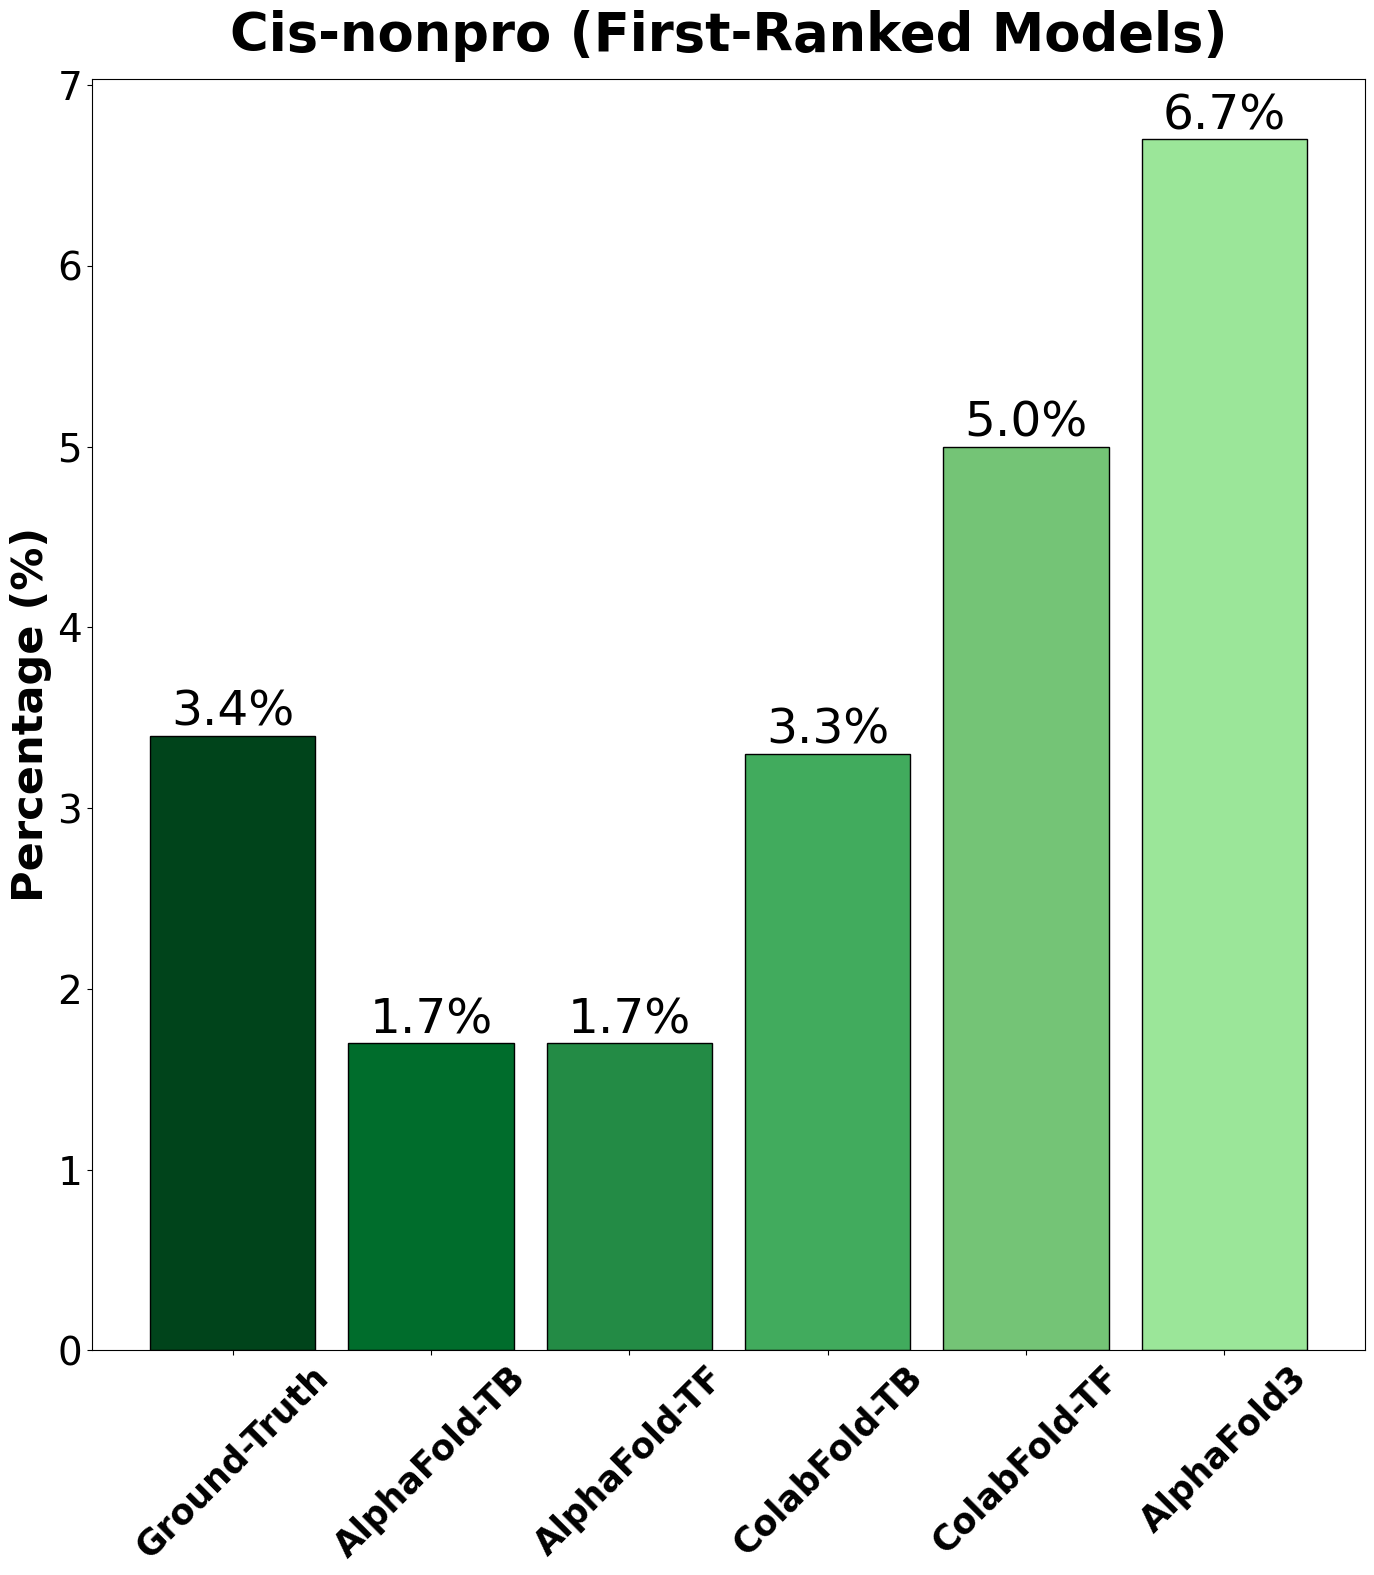

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Cis-nonpro for just first-ranked models
# Data
categories = ['Ground-Truth', 'AlphaFold-TB', 'AlphaFold-TF', 'ColabFold-TB', 'ColabFold-TF', 'AlphaFold3']
non_zero_percentages = [3.4, 1.7, 1.7, 3.3, 5, 6.7]
colors_zero = ['#00441b', '#006d2c', '#238b45', '#41ab5d', '#74c476', '#9be699']  # Using "Zero" color for simplicity

# Plotting setup
fig, ax = plt.subplots(figsize=(14, 16))  # Adjusted figure size for tighter bars
bar_width = 0.5  # Increase bar width to fill more space

# Calculate positions to bring bars closer together
spacing = 0.1  # Decrease spacing between bars
non_zero_bar_positions = np.arange(len(categories)) * (bar_width + spacing)

# Plot "Non-Zero" bars using "Zero" colors for uniformity
bars_non_zero = ax.bar(non_zero_bar_positions, non_zero_percentages, color=colors_zero, edgecolor='black', width=bar_width, label='Non-Zero')

# Add percentages above bars with larger font size
for bar, percentage in zip(bars_non_zero, non_zero_percentages):
    ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height(), f'{percentage:.1f}%', ha='center', va='bottom', fontsize=35)

# Set labels, ticks, and add legend
ax.set_ylabel('Percentage (%)', fontsize=31, fontweight='bold')
ax.set_xticks(non_zero_bar_positions)
ax.set_xticklabels(categories, rotation=45, fontsize=25, fontweight='bold')
plt.yticks(fontsize=28)
ax.set_title('Cis-nonpro (First-Ranked Models)', fontsize=38, fontweight='bold', pad=20)
#plt.legend(fontsize=12)
plt.tight_layout()

# Save the figure using the path from the config variable
output_directory = config['Main_Figures_directory']
output_filename = 'Fig_2c_2.png'
output_path = os.path.join(output_directory, output_filename)
plt.savefig(output_path, format='png', dpi=1000)

# Display the plot
plt.show()


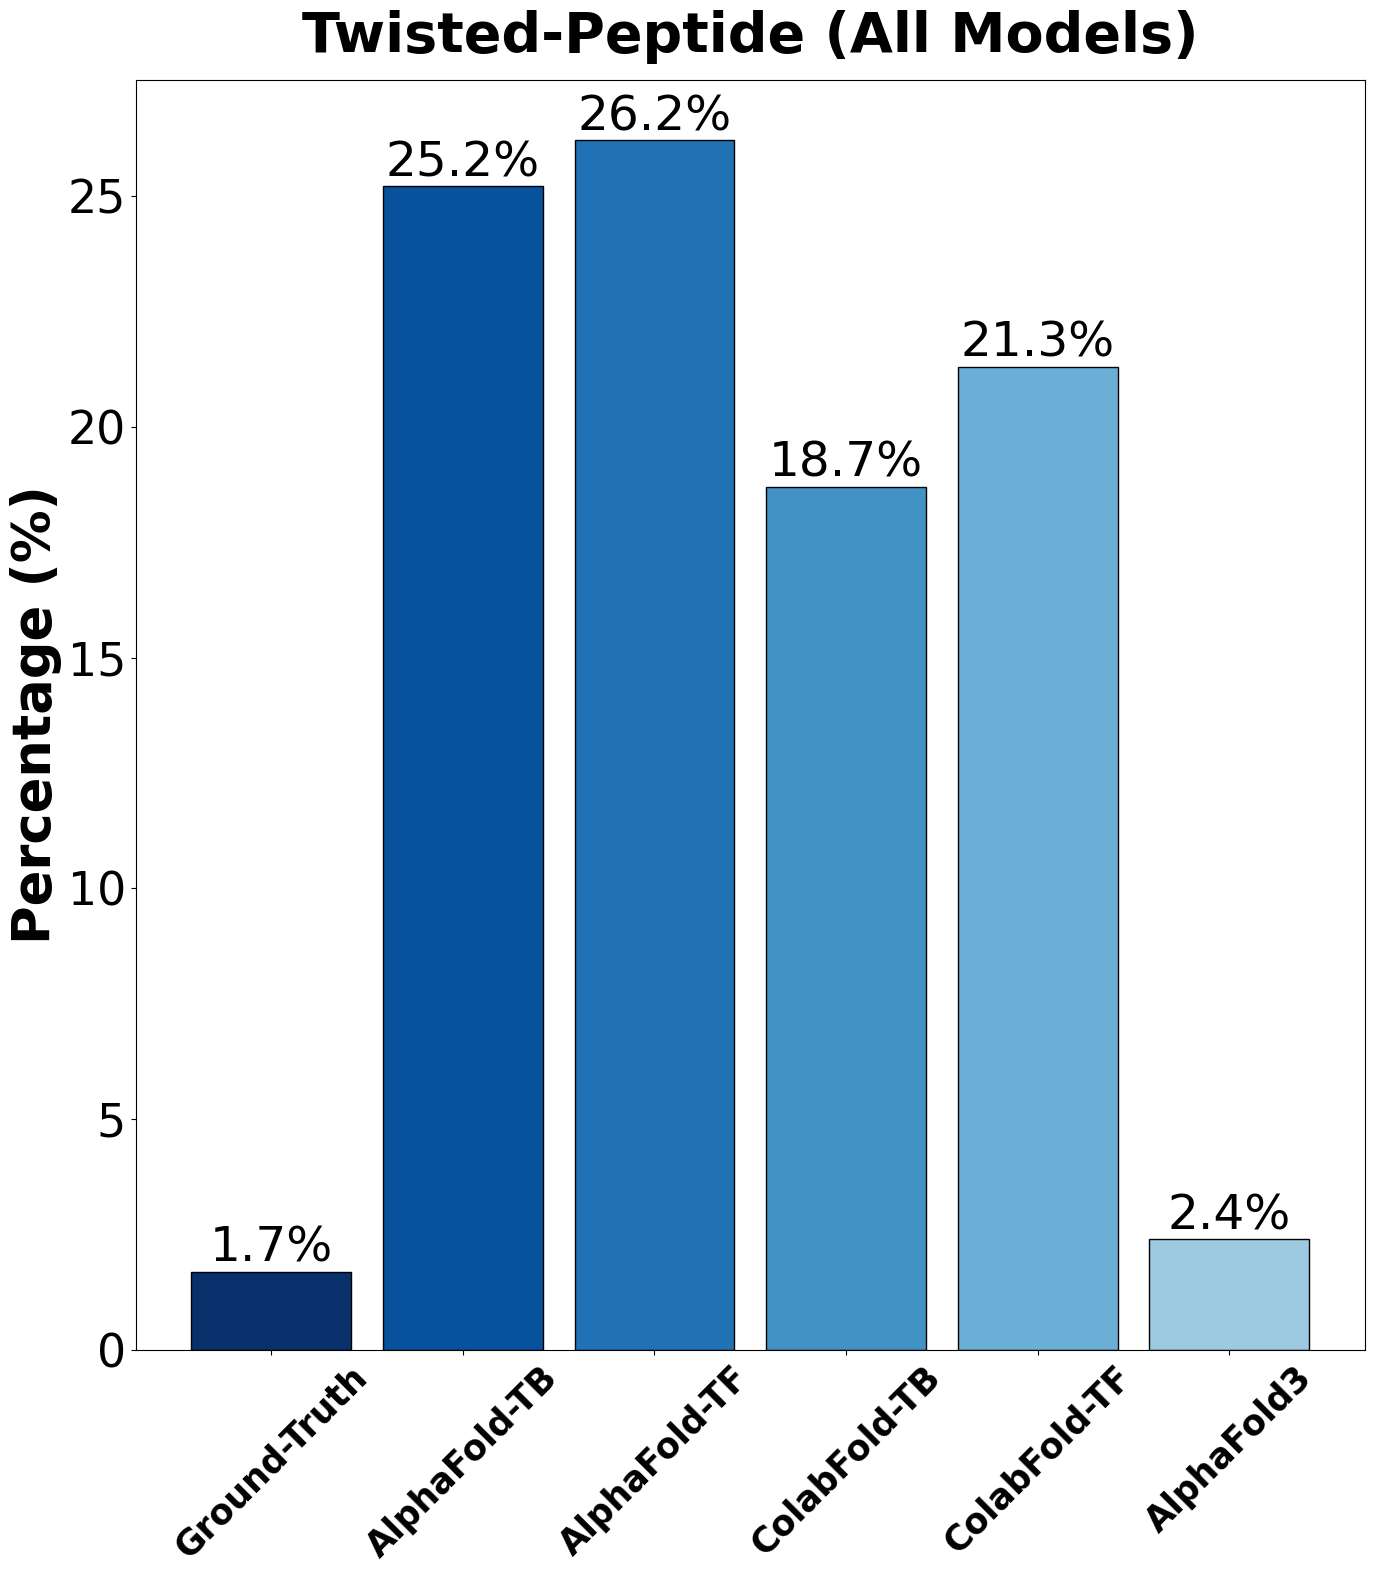

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Twisted-peptide on All samples
# Data
categories = ['Ground-Truth', 'AlphaFold-TB', 'AlphaFold-TF', 'ColabFold-TB', 'ColabFold-TF', 'AlphaFold3']
non_zero_percentages = [1.7, 25.2, 26.2, 18.7, 21.3, 2.4]
colors_zero = ['#08306b', '#08519c', '#2171b5', '#4292c6', '#6baed6', '#9ecae1']  # Using "Zero" colors for simplicity

# Plotting setup
fig, ax = plt.subplots(figsize=(14, 16))  # Adjusted figure size for tighter bars
bar_width = 0.5  # Increase bar width to fill more space

# Calculate positions to bring bars closer together
spacing = 0.1  # Decrease spacing between bars
non_zero_bar_positions = np.arange(len(categories)) * (bar_width + spacing)

# Plot "Non-Zero" bars using "Zero" colors for uniformity
bars_non_zero = ax.bar(non_zero_bar_positions, non_zero_percentages, color=colors_zero, edgecolor='black', width=bar_width, label='Non-Zero')

# Add percentages above bars with larger font size
for bar, percentage in zip(bars_non_zero, non_zero_percentages):
    ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height(), f'{percentage:.1f}%', ha='center', va='bottom', fontsize=35)

# Set labels, ticks, and add legend
ax.set_ylabel('Percentage (%)', fontsize=38, fontweight='bold')
ax.set_xticks(non_zero_bar_positions)
ax.set_xticklabels(categories, rotation=45, fontsize=25, fontweight='bold')
ax.set_title('Twisted-Peptide (All Models)', fontsize=40, fontweight='bold', pad=20)
plt.yticks(fontsize=33)
#plt.legend(fontsize=12)
plt.tight_layout()

# Save the figure using the path from the config variable
output_directory = config['Main_Figures_directory']
output_filename = 'Fig_2b_1.png'
output_path = os.path.join(output_directory, output_filename)
plt.savefig(output_path, format='png', dpi=1000)

# Display the plot
plt.show()


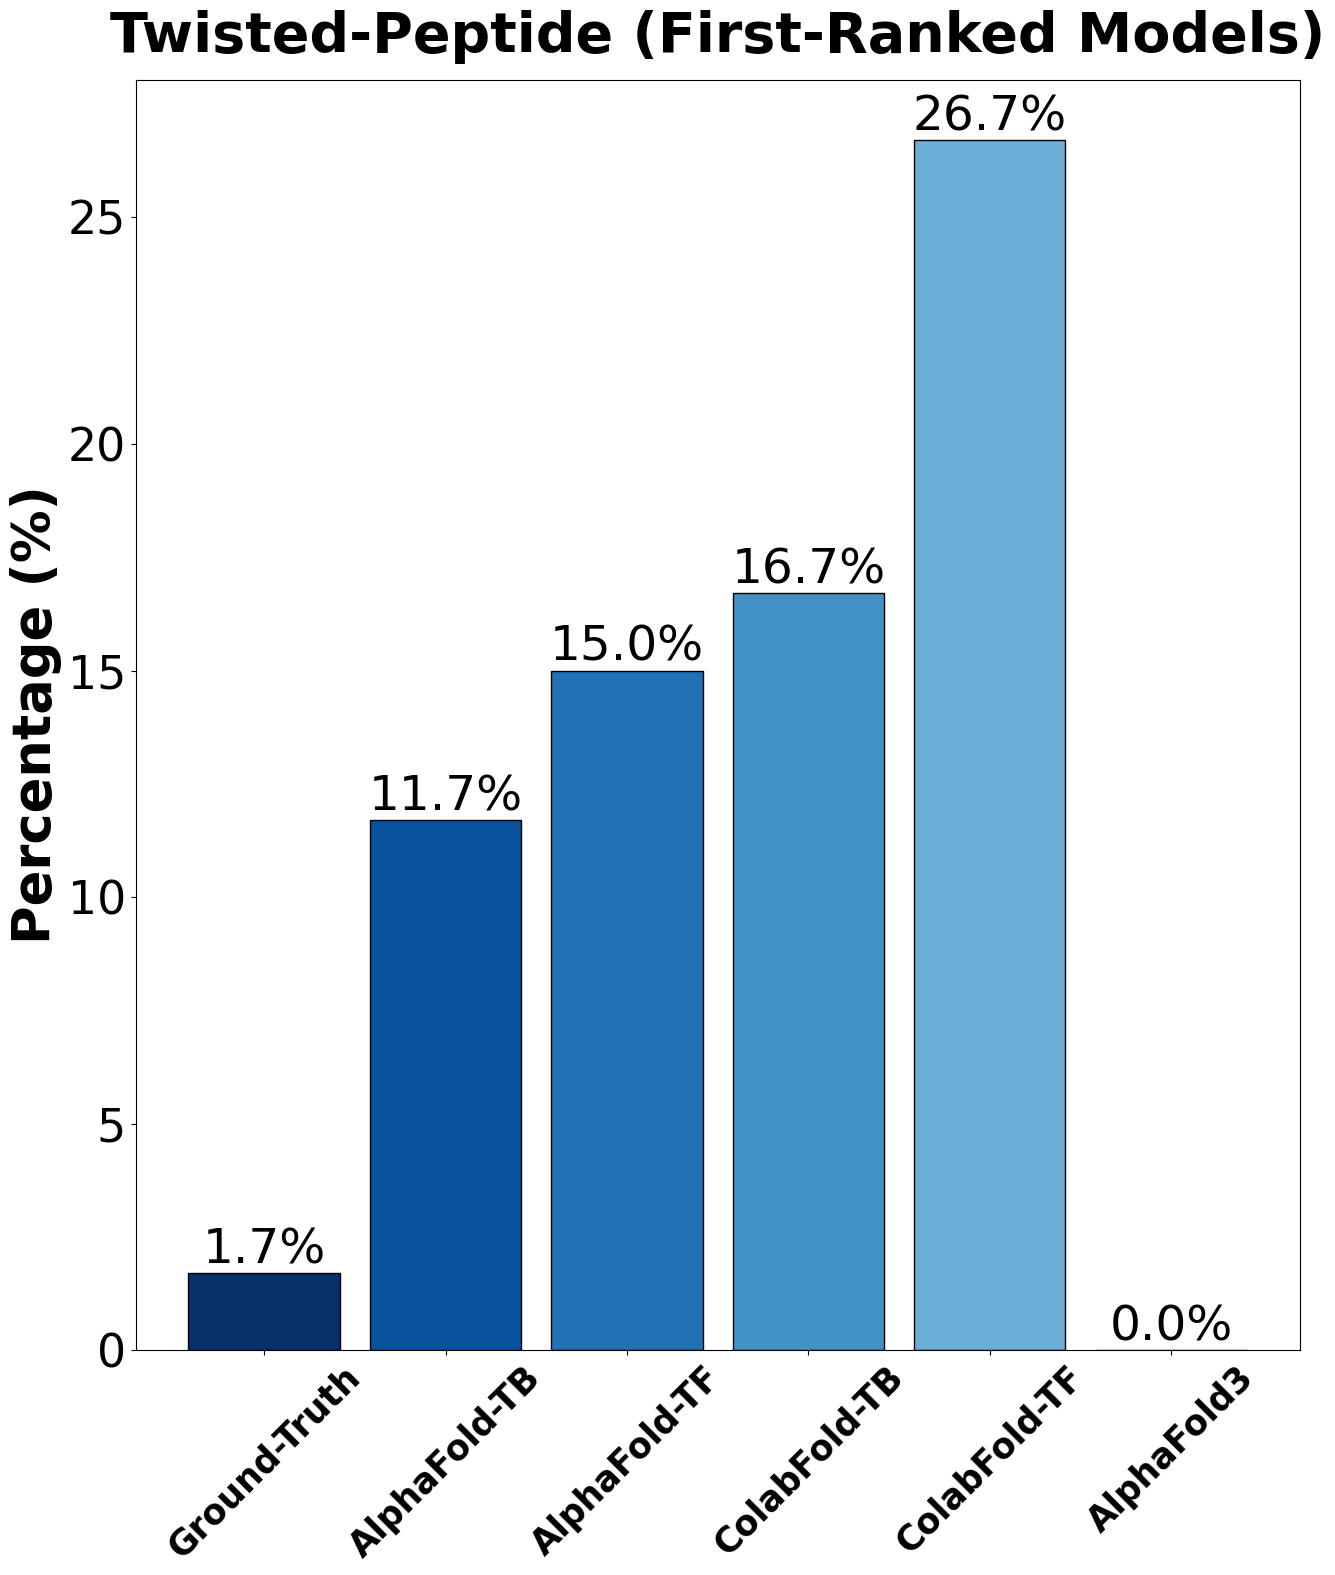

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Twisted-peptide on All samples
# Data
categories = ['Ground-Truth', 'AlphaFold-TB', 'AlphaFold-TF', 'ColabFold-TB', 'ColabFold-TF', 'AlphaFold3']
non_zero_percentages = [1.7, 11.7, 15, 16.7, 26.7, 0]
colors_zero = ['#08306b', '#08519c', '#2171b5', '#4292c6', '#6baed6', '#9ecae1']  # Using "Zero" colors for simplicity

# Plotting setup
fig, ax = plt.subplots(figsize=(14, 16))  # Adjusted figure size for tighter bars
bar_width = 0.5  # Increase bar width to fill more space

# Calculate positions to bring bars closer together
spacing = 0.1  # Decrease spacing between bars
non_zero_bar_positions = np.arange(len(categories)) * (bar_width + spacing)

# Plot "Non-Zero" bars using "Zero" colors for uniformity
bars_non_zero = ax.bar(non_zero_bar_positions, non_zero_percentages, color=colors_zero, edgecolor='black', width=bar_width, label='Non-Zero')

# Add percentages above bars with larger font size
for bar, percentage in zip(bars_non_zero, non_zero_percentages):
    ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height(), f'{percentage:.1f}%', ha='center', va='bottom', fontsize=35)

# Set labels, ticks, and add legend
ax.set_ylabel('Percentage (%)', fontsize=38, fontweight='bold')
ax.set_xticks(non_zero_bar_positions)
ax.set_xticklabels(categories, rotation=45, fontsize=25, fontweight='bold')
ax.set_title('Twisted-Peptide (First-Ranked Models)', fontsize=40, fontweight='bold', pad=20)
plt.yticks(fontsize=33)
#plt.legend(fontsize=12)
plt.tight_layout()

# Save the figure using the path from the config variable
output_directory = config['Main_Figures_directory']
output_filename = 'Fig_2b_2.png'
output_path = os.path.join(output_directory, output_filename)
plt.savefig(output_path, format='png', dpi=1000)

# Display the plot
plt.show()
